###Twitter Sarcasm Detection

####Problem Statement:
To implement a Twitter Sarcasm Detection model that helps to overcome the challenges of identifying the Sarcasm in tweets. 

####Imports

In [ ]:
import numpy as np
import pandas as pd
import re

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc


import warnings
warnings.filterwarnings("ignore")

####Dataset:
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .




In [ ]:
data = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines = True)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
data["is_sarcastic"] = data["is_sarcastic"].map({0: "Not Sarcasm", 1: "Sarcasm"})
data.head()

,is_sarcastic,headline,article_link
0,Sarcasm,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,Not Sarcasm,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,Not Sarcasm,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,Sarcasm,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,Sarcasm,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  object
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: object(3)
memory usage: 670.9+ KB


In [ ]:
#No. of unique categories of tweets
data['is_sarcastic'].nunique()     #the dataset contains Sacastic amd Non-Sarcastic

2

In [ ]:
data.shape

(28619, 3)

####Pre-Processing:

In [ ]:
#Separating positive and negative tweets
data_pos = data[data['is_sarcastic'] == "Sarcasm"]
data_neg = data[data['is_sarcastic'] == "Not Sarcasm"]

In [ ]:
data_pos = data_pos.iloc[:int(10000)]
data_neg = data_neg.iloc[:int(10000)]

In [ ]:
tweets = pd.concat([data_pos, data_neg])
tweets

,is_sarcastic,headline,article_link
0,Sarcasm,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
3,Sarcasm,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,Sarcasm,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
7,Sarcasm,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,Sarcasm,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
...,...,...,...
19154,Not Sarcasm,"julianne moore on 'freeheld,' marriage equalit...",https://www.huffingtonpost.com/entry/julianne-...
19156,Not Sarcasm,report: former nfl kicker threatened students ...,https://www.huffingtonpost.com/entry/students-...
19160,Not Sarcasm,princess charlotte is 'bonding' quite a lot wi...,https://www.huffingtonpost.com/entry/princess-...
19162,Not Sarcasm,wwii veteran reunites with his long-lost love ...,https://www.huffingtonpost.comhttp://pubx.co/L...


In [ ]:
tweets.shape

(20000, 3)

In [ ]:
# Convert text to lowercase
tweets['headline'] = tweets['headline'].str.strip().str.lower()


#####Stopword Removal

In [ ]:
import nltk
import spacy

In [ ]:
# initialize stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_nltk = set(stopwords.words('english'))
print(stop_words_nltk)

{'both', 'into', 'its', 'yourselves', 'had', 'it', 'been', 'so', 'above', 'do', 'hadn', 'with', 'couldn', 'off', 'nor', 'weren', 'don', 'doing', 'too', "couldn't", 'am', 'hers', 'of', "you'd", 'against', 'shouldn', 'itself', 'to', 'didn', 'you', "won't", 'not', 'an', 'wasn', 'here', 'most', 'such', "wouldn't", "that'll", 'those', 'i', 'the', 'they', 'a', 'on', 'further', "you're", 'shan', 'down', 'him', 've', 'me', 'haven', 'their', 'own', 'were', 'before', 'she', 'there', 'as', 'because', 'ma', 'while', "it's", 'all', 'aren', "mightn't", 'them', 'very', 'just', 'is', 'from', 'doesn', 'how', 'he', "hasn't", 'why', 'ain', 'll', "haven't", 'if', 'any', 'wouldn', "hadn't", 'than', 'o', "needn't", 'and', 'has', 'other', "don't", 'be', "isn't", 'his', 'more', 's', 'should', 'our', 'd', "shan't", 'themselves', "should've", 'where', 'ourselves', 'whom', 'what', 'until', 'yours', 'being', 'can', "weren't", 'y', 'then', 'does', 'out', 'myself', "you've", 'below', 'during', 'when', 'your', 'over

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words_nltk ])
tweets['headline'] = tweets['headline'].apply(lambda text: remove_stopwords(text))

In [ ]:
tweets['headline'].head()

0    thirtysomething scientists unveil doomsday clo...
3         inclement weather prevents liar getting work
4    mother comes pretty close using word 'streamin...
7    richard branson's global-warming donation near...
8    shadow government getting large meet marriott ...
Name: headline, dtype: object

#####Punctuation Removal

In [ ]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
tweets['headline']= tweets['headline'].apply(lambda x: remove_punctuations(x))

In [ ]:
tweets['headline'].head()

0    thirtysomething scientists unveil doomsday clo...
3         inclement weather prevents liar getting work
4    mother comes pretty close using word streaming...
7    richard bransons globalwarming donation nearly...
8    shadow government getting large meet marriott ...
Name: headline, dtype: object

#####URL Removal

In [ ]:
def remove_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text)
tweets['headline'] = tweets['headline'].apply(lambda x: remove_URLs(x))

In [ ]:
tweets['headline'].head()

0    thirtysomething scientists unveil doomsday clo...
3         inclement weather prevents liar getting work
4    mother comes pretty close using word streaming...
7    richard bransons globalwarming donation nearly...
8    shadow government getting large meet marriott ...
Name: headline, dtype: object

#####Tokenization

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
tweets['headline'] = tweets['headline'].apply(tokenizer.tokenize)

In [ ]:
tweets['headline'].head()

0    [thirtysomething, scientists, unveil, doomsday...
3    [inclement, weather, prevents, liar, getting, ...
4    [mother, comes, pretty, close, using, word, st...
7    [richard, bransons, globalwarming, donation, n...
8    [shadow, government, getting, large, meet, mar...
Name: headline, dtype: object

#####Stemming

In [ ]:
from nltk.stem import PorterStemmer
stemmer= PorterStemmer()

In [ ]:
def stemming(text):
    text=[stemmer.stem(word) for word in text]
    return text
tweets['headline'] = tweets['headline'].apply(lambda x: stemming(x))


In [ ]:
tweets['headline'].head()

0    [thirtysometh, scientist, unveil, doomsday, cl...
3       [inclement, weather, prevent, liar, get, work]
4    [mother, come, pretti, close, use, word, strea...
7    [richard, branson, globalwarm, donat, nearli, ...
8    [shadow, govern, get, larg, meet, marriott, co...
Name: headline, dtype: object

#####Lemmatization

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lm = nltk.WordNetLemmatizer()
def lemmatization(data):
    text = [lm.lemmatize(word) for word in data]
    return data
tweets['headline'] = tweets['headline'].apply(lambda x: lemmatization(x))
tweets['headline'].head()

0    [thirtysometh, scientist, unveil, doomsday, cl...
3       [inclement, weather, prevent, liar, get, work]
4    [mother, come, pretti, close, use, word, strea...
7    [richard, branson, globalwarm, donat, nearli, ...
8    [shadow, govern, get, larg, meet, marriott, co...
Name: headline, dtype: object

####Data Visualization:
Plotting a cloud of words for negative and positive tweets

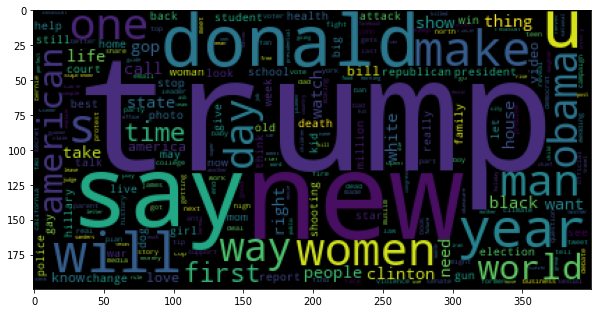

In [ ]:
data_neg = data_neg['headline']
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 500 ,collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

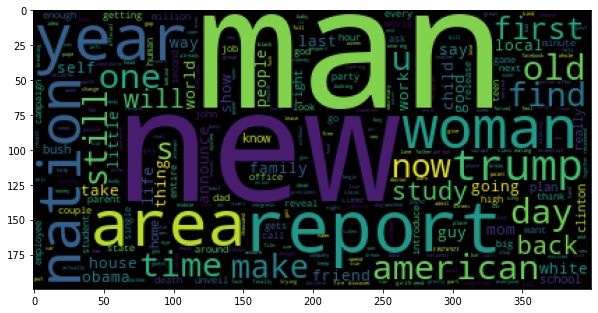

In [ ]:
data_pos = data_pos['headline']
wc1 = WordCloud(max_words = 500,collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (10,10))
plt.imshow(wc1)

####Data-Splitting:

In [ ]:
#converting token of words to sentence
def join(text):
    text=' '.join(text)
    return text
tweets['headline'] = tweets['headline'].apply(lambda x: join(x))
tweets['headline'].head()

0    thirtysometh scientist unveil doomsday clock h...
3              inclement weather prevent liar get work
4    mother come pretti close use word stream corre...
7    richard branson globalwarm donat nearli much c...
8    shadow govern get larg meet marriott confer ro...
Name: headline, dtype: object

In [ ]:
X=tweets.headline
y=tweets.is_sarcastic

In [ ]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =42)

####Feature Vectorization:
Application of 3 different techniques of feature vectorization on the preprocessed dataset namely: bag of words, bag of ngrams and TF-IDF, and their subsequent comparitive analysis.

#####TF-IDF Vectorizer

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)

TfidfVectorizer(ngram_range=(1, 2))

In [ ]:
#Transforming the data
X_train1 = tfidf.transform(X_train)
X_test1  = tfidf.transform(X_test)

#####Bag of N-Grams

In [ ]:
bon = CountVectorizer(ngram_range=(1,3))
bon.fit(X_train)

CountVectorizer(ngram_range=(1, 3))

In [ ]:
#Transforming the data
X_train2 = bon.transform(X_train)
X_test2  = bon.transform(X_test)

#####Bag of Words

In [ ]:
bow = CountVectorizer()
bow.fit(X_train)

CountVectorizer()

In [ ]:
#Transforming the data
X_train3 = bow.transform(X_train)
X_test3  = bow.transform(X_test)

####Model Evaluation :
Application of  evaluation measures namely: Accuracy score and Confusion matrix,to check how the different models perform on the vectorized dataset.

In [ ]:
def model_Evaluate(model,test_data):
    # Predict values for Test dataset
    y_pred = model.predict(test_data)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Positive','Negative']
    group_names = ['True Pos','False Neg','True Neg','False Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'crest',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 5)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 5)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 10)

####Models:
Application of 2 models: Logistic Regression and Random Forest with dataset represented by three different feature vectorization techniques and their subsequent comparitive analysis.

#####Logistic Regression

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)


              precision    recall  f1-score   support

 Not Sarcasm       0.78      0.78      0.78       489
     Sarcasm       0.79      0.79      0.79       511

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



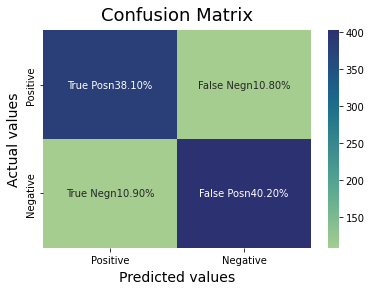

In [ ]:
#Using TF-IDF Vectorized data
LRmodel.fit(X_train1, y_train)
model_Evaluate(LRmodel,X_test1)


              precision    recall  f1-score   support

 Not Sarcasm       0.75      0.84      0.79       489
     Sarcasm       0.83      0.74      0.78       511

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



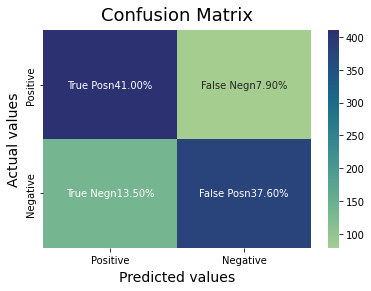

In [ ]:
#Using Bag of N-grams Vectorized data
LRmodel.fit(X_train2, y_train)
model_Evaluate(LRmodel,X_test2)

              precision    recall  f1-score   support

 Not Sarcasm       0.74      0.79      0.76       489
     Sarcasm       0.79      0.73      0.76       511

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



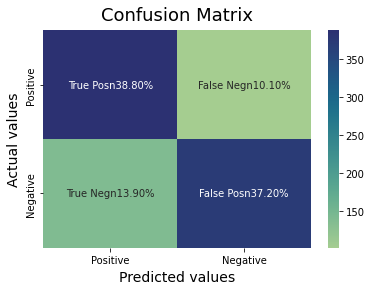

In [ ]:
#Using Bag of words Vectorized data
LRmodel.fit(X_train3, y_train)
model_Evaluate(LRmodel,X_test3)

#####Random Forest

In [ ]:
RFmodel=RandomForestClassifier(n_estimators = 100)

              precision    recall  f1-score   support

 Not Sarcasm       0.68      0.86      0.76       489
     Sarcasm       0.82      0.61      0.70       511

    accuracy                           0.73      1000
   macro avg       0.75      0.73      0.73      1000
weighted avg       0.75      0.73      0.73      1000



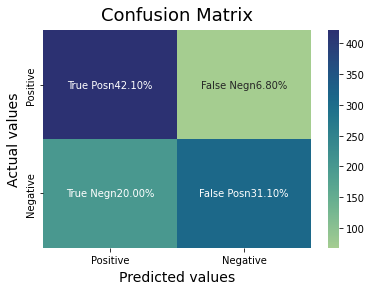

In [ ]:
#Using TF-IDF Vectorized data
RFmodel.fit(X_train1, y_train)
model_Evaluate(RFmodel,X_test1)

              precision    recall  f1-score   support

 Not Sarcasm       0.69      0.89      0.78       489
     Sarcasm       0.85      0.61      0.71       511

    accuracy                           0.75      1000
   macro avg       0.77      0.75      0.74      1000
weighted avg       0.77      0.75      0.74      1000



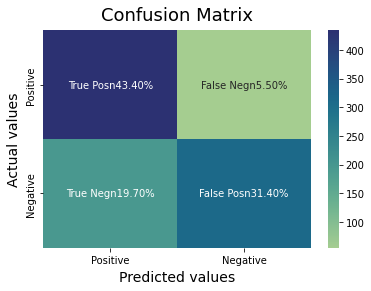

In [ ]:
#Using Bag of N-grams Vectorized data
RFmodel.fit(X_train2, y_train)
model_Evaluate(RFmodel,X_test2)

              precision    recall  f1-score   support

 Not Sarcasm       0.71      0.84      0.77       489
     Sarcasm       0.81      0.67      0.73       511

    accuracy                           0.75      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.76      0.75      0.75      1000



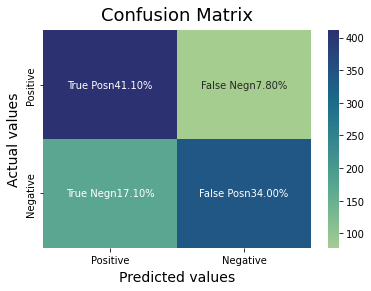

In [ ]:
#Using Bag of words Vectorized data
RFmodel.fit(X_train3, y_train)
model_Evaluate(RFmodel,X_test3)

In [ ]:
!jupyter nbconvert --to html ""